# Lesson goal
---
* Understand the architecture of the vanilla LSTM
* From memory copy Jeff Heaton's show case of the LSTM.


In this particular problem, I want to simulate a car travelling down a road, and it has 1 of 3 colors. Sometimes it will be caught in the first frame, sometimes in the second. Sometimes the car is long and takes up multiple frames, sometimes it is short and takes up only one. I just want the color returned.

---
---
---

# Necessary Setup (ignore it)

In [63]:
# Necessary imports, okay to ignore
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import numpy as np

# Keras import
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
#from tensorflow.python.ops.math_ops import reduce_prod
import numpy as np
import pandas as pd
import random
import sys
import io
import requests
import re

# I also want to hide stinky warning boxes, and 
# this: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
# had some solutions.
def hide_warnings():
    from IPython.display import HTML
    HTML('''<script>
    var code_show_err = false; 
    var code_toggle_err = function() {
     var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
     var stderr = Array.from(stderrNodes)
     if (code_show_err){
         stderr.forEach(ele => ele.style.display = 'block');
     } else {
         stderr.forEach(ele => ele.style.display = 'none');
     }
     code_show_err = !code_show_err
    } 
    document.addEventListener('DOMContentLoaded', code_toggle_err);
    </script>
    To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')
###########################################################

np.random.seed(42)
pd.set_option('display.max_rows', 1000)
pd.set_option( 'display.max_colwidth', None )

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
hide_warnings()

Tensor Flow Version: 2.4.0
Keras Version: 2.4.0

Python 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
Pandas 1.3.3
Scikit-Learn 1.0
GPU is NOT AVAILABLE


2022-01-23 11:35:26.880317: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [30]:
# I need a general function that, given a list and 
# what categories I expect, generate a one-hot encoding.
def make_dummies(sequence, categories=None):
    # Given a list "sequence" return it one-hot encoded
    # This automatically finds all the unique values in
    # the input and makes them the categories. Requires
    # numpy and pandas as imports
    if not categories:
        categories = set(np.array(sequence).flatten())
    sequence = pd.DataFrame(sequence, 
                            dtype=pd.CategoricalDtype(categories=categories))
    sequence = pd.get_dummies(sequence)
    return np.array(sequence)

# Making my mock dataset

In [10]:
# Making the dataset
colors = [1,2,3]
mock_dataset = [[0,0,1,1,0],  # Each row is an "observation" of cars passing in front of a "camera"
                [0,1,1,1,0],  # A zero means no car, and a number means a car with a color.
                [2,0,0,0,0],
                [0,0,0,2,2],
                [0,0,3,3,0],
                [2,2,0,0,0],
                [0,0,0,2,2],
                [3,3,0,0,0],
                [2,2,2,0,0],
                [0,0,1,0,0]
               ]
mock_dataset = make_dummies(mock_dataset).reshape(10, 5, 4)

# Making the "answer key"
mock_y = [1,1,2,2,3,2,2,3,2,1]
mock_y = make_dummies(mock_y,categories=colors).reshape(10,3)

In [66]:
print("Dataset input, first two rows as one-hot")
display(mock_dataset[0:2,:,:])
print('\nDataset expected outputs')
display(mock_y[0:5])

Dataset input, first two rows as one-hot


array([[[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0]]], dtype=uint8)


Dataset expected outputs


array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

# Making the neural net

In [33]:
# Wow this is super simple to implement
model = Sequential()
# I just chose 20 randomly
model.add(LSTM(20, input_shape=(5,4)))
# I have 3 color outputs
model.add(Dense(3, activation='softmax'))
# Chose categorical_crossentropy because I have more than
# two classes. This is multinomial. The optimizer seems
# like it doesn't super super matter here.
model.compile(loss='categorical_crossentropy', 
              optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2000      
_________________________________________________________________
dense (Dense)                (None, 3)                 63        
Total params: 2,063
Trainable params: 2,063
Non-trainable params: 0
_________________________________________________________________


# Training the neural net

In [34]:
# Train the model on our data!
hist = model.fit(mock_dataset, mock_y, 
                 epochs=70, verbose=0,
                 batch_size=3)
hist.history['loss'][-1]
# a loss of 0.093 is very good, but
# slightly conserning that it is overfit.
# Lets test it!

0.0931914821267128

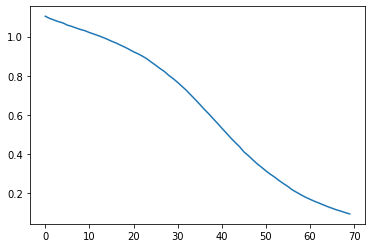

In [68]:
plt.plot(hist.history['loss'])

# Manually evaluating its performance!

In [62]:
# Make up a new input that the model hasn't seen
# and see if it performs well!
new_input = [0,3,0,0,0]
new_input = make_dummies(new_input, categories=[0,1,2,3]).reshape(1,5,4)
yhat = model.predict(new_input)
display("Raw LSTM output",yhat)
print("\n\nPredicted color value: ",colors[np.argmax(yhat)])

'Raw LSTM output'

array([[0.15906216, 0.19738959, 0.64354825]], dtype=float32)



Predicted color value:  3


In [86]:
# Lets make a little function we 
# can play around with
def interactive_eval():
    new_input = []
    count = 0
    while(True):
        if count:
            new_input = input("Give me a list of numbers: |||||||")
        else:
            new_input = input("Give me a list of numbers like so: 0 0 1 0 0 |||||||")
        if(new_input == 'done'): break
        input_for_net = new_input.strip().split(' ')
        input_for_net = np.array(input_for_net, dtype='int64')
        input_for_net = make_dummies(input_for_net, categories=[0,1,2,3]).reshape(1,5,4)
        yhat = model.predict(input_for_net)
        print("Raw LSTM output",yhat)
        print("Predicted color value: ",colors[np.argmax(yhat)], '\n\n=======================================\n')
        count += 1

# Interactivally evaluate performance!

In [85]:
interactive_eval()

Give me a list of numbers like so: 0 0 1 0 0 ||||||| 1 0 0 0 0


Raw LSTM output [[0.90688604 0.05808943 0.03502443]]
Predicted color value:  1 




Give me a list of numbers: ||||||| 0 2 0 0 0


Raw LSTM output [[0.00928223 0.9867401  0.00397775]]
Predicted color value:  2 




Give me a list of numbers: ||||||| done
